In [1]:
# have waypoints
# plot contours? for wind?
# boat polars? downwind/upwind speed, 45 degree speed
# 

# how is it related to argo which can only go up/down?


In [2]:
# be able to model the currents / visualize them
# define path 
# node edge vertex...

# okay, and depth

# Okay, so define a dataset. Then implement RRT*. Just have custom cost metric...
# apt install libcgal-dev
# git clone 
# cd; libcgal-dev
import numpy as np
import matplotlib.pyplot as plt
import skgeom as sg
from skgeom.draw import draw

# RRT Pseudo CodeQgoal //region that identifies success
Counter = 0 //keeps track of iterations
lim = n //number of iterations algorithm should run for
G(V,E) //Graph containing edges and vertices, initialized as empty
While counter < lim:
    Xnew  = RandomPosition()
    if IsInObstacle(Xnew) == True:
        continue
    Xnearest = Nearest(G(V,E),Xnew) //find nearest vertex
    Link = Chain(Xnew,Xnearest)
    G.append(Link)
    if Xnew in Qgoal:
        Return G
Return G


In [3]:
#edge: startID, endID? or just define by the two x,y coordinates

class Graph:
    def __init__(self):   
        self.nodeslist = []
        self.edgeslist = []

In [11]:
class RRTProblem_2D:#PlanningProblem):
    def __init__(self):
        XLIM = 5 
        YLIM = 3
        
        # Hardcode everything for now
        #self.worldstate = {'xlim': XLIM, 'ylim': YLIM, 'obstacles': None}
        self.worldstate = {'xlim': XLIM, 'ylim': YLIM, 
                           'obstacles': [ [[1,1], [1,2], [2,2], [2,1]] ],
                           #'obstacles': [ -1 * np.array([[1,1], [1,2], [2,2], [2,1]]) ],
                           'field': [[]]}
                        #'obstacles': None}
        print(self.worldstate['obstacles'])
        self.startstate = (0,0)
        self.goalstate = (XLIM, YLIM)
        self.goalradius = 0.5
        
        self.nIters = 0
        self.limit_iterations = 1000
        
        self.g = Graph()
        self.g.nodeslist.append(self.startstate)
        self.MAX_DISTANCE = np.sqrt(XLIM**2 + YLIM**2) + 1
        
        self.connectradius = 0.5
        
    def sampleFree(self):
        success = False
        while not success:     
            xnew = self.sampleRandomly()
            nearest = self.findNearest(xnew)
            print('found free xnew', xnew)
            print('found nereat', xnew, nearest)
            if not self.isColliding(xnew, nearest):
                print('found free edge', xnew, nearest)
                success = True
        print('returning: xnew', xnew, 'nearest', nearest)
        return xnew, nearest
        
        
    def sampleRandomly(self):
        rand_x = np.random.rand() * self.worldstate['xlim']
        rand_y = np.random.rand() * self.worldstate['ylim']
        return rand_x, rand_y
    
    def isColliding(self, node, prevnode = None):
        # no obstacles for now
        pt = sg.Point2(*node)
        for obs_coords in self.worldstate['obstacles']:
            obstacle = sg.Polygon(obs_coords)
            # Check is Node in Obstacle
            if obstacle.oriented_side(pt) == -1 or obstacle.oriented_side(pt) == 0:
                return True 
            # Check if Edge linking PrevNode, Node crosses obstacle
            if prevnode is not None:
                candidate_edge = sg.Segment2(sg.Point2(*node), sg.Point2(*prevnode))
                for e in obstacle.edges:
                    if sg.intersection(e, candidate_edge) is not None:
                        return True                
        return False
    
    
    def measureDistance(self, fromPt, toPt):
        # 2d Euclidean distance
        #return np.sqrt((toPt.x - fromPt.x)**2 + (toPt.y - fromPt.y)**2)
        euclid_dist =  np.sqrt((toPt[0] - fromPt[0])**2 + (toPt[1] - fromPt[1])**2)
        return euclid_dist 
    
    def inGoalRegion(self, node):
        distance_remaining = self.measureDistance(node, self.goalstate)
        if distance_remaining < self.goalradius:
            print('!-- In goal. distance_remaining', distance_remaining)
            return True
        return False
        
    def findNearest(self, node):
        mindist = self.MAX_DISTANCE 
        nearest = None
        print('len nodeslist', len(self.g.nodeslist))
        for candidate in self.g.nodeslist:
            dist = self.measureDistance(candidate, node)
            if dist < mindist:
                # nearest only counts if the edge doesn't go through obstacle
                nearest = candidate
                mindist = dist
                print('mindist', mindist, candidate, node)
        return nearest
    
    def updateGraph(self, xnew, nearest):
        # OLD: Directly append
        #self.g.edgeslist.append((nearest, xnew))
        #self.g.nodeslist.append(xnew)
        # Limit distance of new node from old node
        if self.measureDistance(xnew, nearest) > self.connectradius:
            tantheta = np.arctan2((xnew[1] - nearest[1]), (xnew[0] - nearest[0]))
            closerx = nearest[0] + self.connectradius * np.cos(tantheta)
            closery = nearest[1] + self.connectradius * np.sin(tantheta)
            xnew = (closerx, closery)
        self.g.edgeslist.append((nearest, xnew))
        self.g.nodeslist.append(xnew)
        return xnew 
            
    def runRRT(self):
        print('!-- runing RRT')
        while self.nIters < self.limit_iterations:
            self.nIters += 1
            print('!------ self iters', self.nIters)
            xnew, nearest = self.sampleFree()
            xnew = self.updateGraph(xnew, nearest) #
            print('appended xnew and nearest')
            if self.inGoalRegion(xnew):
                print('\n!-- SUCCESS', 'nodes list len ', len(self.g.nodeslist), 'edges len', len(self.g.edgeslist))
                return 'success', self.g
        return 'fail', self.g
    
    def runTest(self):
        m = self.measureDistance((1,1), (1,1))
        print(m)
        m = self.measureDistance((0,1), (1,1))
        print(m)
        m = self.measureDistance((0,0), (1,1))
        print(m)
        self.g.nodeslist = [(1,1), (1, 0.5), (0,0), (0.5, 0)]
        n = self.findNearest((1,0.4))
        print(n)
        

In [12]:
problem = RRTProblem_2D()
success, rrt_graph = problem.runRRT()
print('\nsuccess?', success)

[[[1, 1], [1, 2], [2, 2], [2, 1]]]
!-- runing RRT
!------ self iters 1
len nodeslist 1
mindist 4.412604082428533 (0, 0) (3.2474636546307876, 2.987482987418842)
found free xnew (3.2474636546307876, 2.987482987418842)
found nereat (3.2474636546307876, 2.987482987418842) (0, 0)
len nodeslist 1
mindist 2.6718727330982572 (0, 0) (0.30798104444315577, 2.654063220448536)
found free xnew (0.30798104444315577, 2.654063220448536)
found nereat (0.30798104444315577, 2.654063220448536) (0, 0)
found free edge (0.30798104444315577, 2.654063220448536) (0, 0)
returning: xnew (0.30798104444315577, 2.654063220448536) nearest (0, 0)
appended xnew and nearest
!------ self iters 2
len nodeslist 2
mindist 2.0453862975055626 (0, 0) (1.8697482133055425, 0.829244671290835)
mindist 1.8423805090622154 (0.05763392856029231, 0.4966672228753445) (1.8697482133055425, 0.829244671290835)
found free xnew (1.8697482133055425, 0.829244671290835)
found nereat (1.8697482133055425, 0.829244671290835) (0.05763392856029231, 0.

In [13]:
#problem.runTest()

# Calc win Path

In [14]:
from copy import deepcopy
def calcWinPath(graph):
    # assume first node added is start state; last node added is node in goal region 
    path = []
    path.append(graph.edgeslist[-1])
    g = deepcopy(graph)
    DEBUG = True
    MAXITER = 99999
    if DEBUG:
        MAXITER = 2000
    
    def findPrevEdge(edge):
        prevEdge = None
        for nIters, e in enumerate(g.edgeslist):
            if nIters > MAXITER:
                print(nIters, 'BREAK')
                break
            nIters += 1
            if e[1] == edge[0]:
                g.edgeslist.remove(e)
                prevEdge = e 
                break
        return prevEdge
    
    success = False
    prevEdge = graph.edgeslist[-1]
    nIters = 0
    while nIters < MAXITER and not success:
        nIters += 1
        prevEdge = findPrevEdge(prevEdge)
        path.append(prevEdge)
        if prevEdge is not None:
            if prevEdge[0] == (0,0):
                success = True
    return success, path
    
print(rrt_graph.edgeslist[-1])
success, winpath = calcWinPath(rrt_graph)
print('success?', success, '\n\n', winpath)
#print(rrt_graph.edgeslist)

((4.1354744229769995, 1.4334633820776375), (4.4305664037443835, 1.8370977746741826))
success? True 

 [((4.1354744229769995, 1.4334633820776375), (4.4305664037443835, 1.8370977746741826)), ((3.893707236780477, 0.9958006949787532), (4.1354744229769995, 1.4334633820776375)), ((3.4337857426897744, 0.799657330896825), (3.893707236780477, 0.9958006949787532)), ((2.9601640612370916, 0.9599149449372616), (3.4337857426897744, 0.799657330896825)), ((2.5192309271118014, 1.1956647513644327), (2.9601640612370916, 0.9599149449372616)), ((2.0500618692067767, 1.33159584063208), (2.5192309271118014, 1.1956647513644327)), ((2.0256926740899623, 0.8321900513891453), (2.0500618692067767, 1.33159584063208)), ((1.5372250375904706, 0.7254222280873637), (2.0256926740899623, 0.8321900513891453)), ((1.0383842412950002, 0.6913948868556288), (1.5372250375904706, 0.7254222280873637)), ((0.5494200378444242, 0.586924758378902), (1.0383842412950002, 0.6913948868556288)), ((0.05763392856029231, 0.4966672228753445), (0

# Plot Room Path

[((4.1354744229769995, 1.4334633820776375), (4.4305664037443835, 1.8370977746741826)), ((3.893707236780477, 0.9958006949787532), (4.1354744229769995, 1.4334633820776375)), ((3.4337857426897744, 0.799657330896825), (3.893707236780477, 0.9958006949787532)), ((2.9601640612370916, 0.9599149449372616), (3.4337857426897744, 0.799657330896825)), ((2.5192309271118014, 1.1956647513644327), (2.9601640612370916, 0.9599149449372616)), ((2.0500618692067767, 1.33159584063208), (2.5192309271118014, 1.1956647513644327)), ((2.0256926740899623, 0.8321900513891453), (2.0500618692067767, 1.33159584063208)), ((1.5372250375904706, 0.7254222280873637), (2.0256926740899623, 0.8321900513891453)), ((1.0383842412950002, 0.6913948868556288), (1.5372250375904706, 0.7254222280873637)), ((0.5494200378444242, 0.586924758378902), (1.0383842412950002, 0.6913948868556288)), ((0.05763392856029231, 0.4966672228753445), (0.5494200378444242, 0.586924758378902)), ((0, 0), (0.05763392856029231, 0.4966672228753445))]
e ((4.135

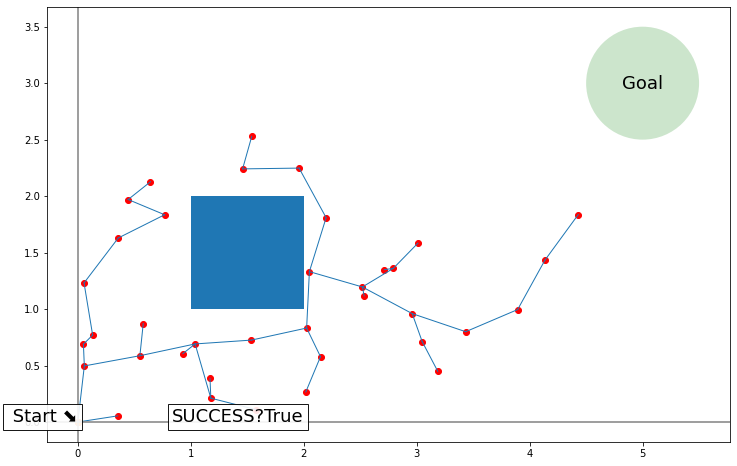

In [16]:
%matplotlib inline 
def plotRRT(succeeded, graph, winpath=None, goal_state = (5,3), goal_radius=0.5,
            obstacles=[ [[1,1], [1,2], [2,2], [2,1]] ]):
    plt.figure(figsize=(6,8))
    #plt.axes()
    goal = plt.Circle(goal_state, radius=goal_radius, fc='g', alpha=0.2)
    plt.gca().add_patch(goal)
    
    plt.gca().add_patch(plt.Rectangle((1, 1), 1,1))
    
    plt.text(goal_state[0]-0.18, goal_state[1]-0.05, 'Goal', fontsize=18)
    plt.text(0,0, ' Start ⬊', fontsize=18, bbox=dict(alpha=0.9, fc='white'), ha='right')
    plt.scatter(0,0, )
    for node in graph.nodeslist:
        #print(node)
        plt.scatter(node[0], node[1], color='red')
    for edge in graph.edgeslist:
        ptA, ptB = edge[0], edge[1]
        # x1 x2 y1 y2
        line = plt.Line2D((ptA[0], ptB[0]), (ptA[1], ptB[1]), lw=1)
        plt.gca().add_line(line)
    plt.text(2,0, 'SUCCESS?' + str(succeeded), fontsize=18, bbox=dict(alpha=0.9, fc='white'), ha='right')
    plt.scatter(0,0, )
    if winpath:
        for e in winpath:
            print('e',e)
            '''
            ptA, ptB = e[0], e[1]
            line = plt.Line2D((ptA[0], ptB[0]), (ptA[1], ptB[1]), c='lightgreen', lw=4)
            plt.gca().add_line(line)
            '''
            
    plt.axhline(0,color='gray') # x = 0
    plt.axvline(0,color='gray') # y = 0
    plt.axis('scaled')
    plt.subplots_adjust(left=-1)
    plt.show()
    
#my_fig = plotRRT(True, rrt_graph)
print(winpath)
my_fig = plotRRT(success, rrt_graph, winpath)